# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
np.random.seed(2)

# Data

In [4]:
path = untar_data(URLs.PETS)

In [5]:
path

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet')

In [6]:
path.ls()

['annotations', 'images']

In [7]:
path_anno = path/'annotations'
path_img = path/'images'

In [8]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Russian_Blue_106.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Russian_Blue_61.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_116.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_82.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/samoyed_186.jpg')]

## Load data

In [9]:
pat = r'/([^/]+)_\d+.jpg$'

In [10]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224)

In [11]:
# normalize (same mean and sd) for each pixel channel (rgb) value
# motivation: control for variation in camera brightness
data.normalize(imagenet_stats)

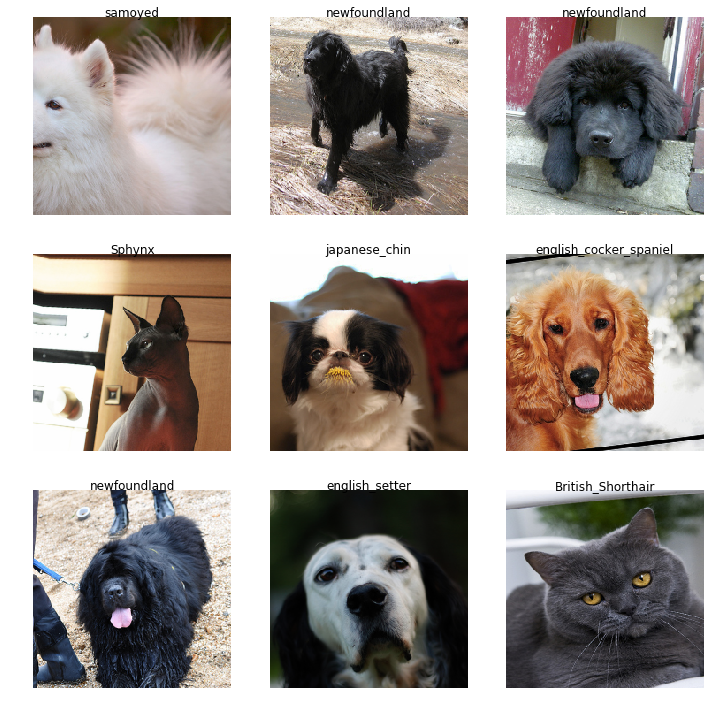

In [393]:
data.show_batch(rows=3, figsize=(10,10))

In [13]:
print(data.classes)
len(data.classes),data.c

['Russian_Blue', 'staffordshire_bull_terrier', 'samoyed', 'japanese_chin', 'Ragdoll', 'saint_bernard', 'boxer', 'Siamese', 'leonberger', 'pomeranian', 'basset_hound', 'american_pit_bull_terrier', 'wheaten_terrier', 'american_bulldog', 'great_pyrenees', 'beagle', 'scottish_terrier', 'keeshond', 'Persian', 'english_cocker_spaniel', 'havanese', 'newfoundland', 'Sphynx', 'British_Shorthair', 'Bombay', 'shiba_inu', 'Egyptian_Mau', 'Abyssinian', 'Maine_Coon', 'yorkshire_terrier', 'chihuahua', 'miniature_pinscher', 'pug', 'english_setter', 'german_shorthaired', 'Birman', 'Bengal']


(37, 37)

# Train

## Final Layer Only

In [14]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4,max_lr=3*10**-3)

Total time: 02:10
epoch  train loss  valid loss  error_rate
1      1.145205    0.300571    0.097804    (00:36)
2      0.526884    0.293723    0.101131    (00:31)
3      0.308443    0.245170    0.081836    (00:31)
4      0.226890    0.231674    0.079840    (00:31)



## Previous Layers Also

In [ ]:
# unfreeze
learn.unfreeze()
# find best learning rate
learn.lr_find()
learn.recorder.plot()

In [22]:
#train previous layers also
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))



Total time: 01:03
epoch  train loss  valid loss  error_rate
1      0.200365    0.232503    0.082502    (00:31)
2      0.176226    0.221809    0.074518    (00:32)



# Get last layer

In [23]:
# this is a hook (learned about it here: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [50]:
#model to eval mode (don't use dropout anymore)
learn.model.eval()

# Get validation features

# specify layer to store (last real layer before the predictions (last two are a dropout layer and the actual predictions))
sf = SaveFeatures(learn.model[-1][-3])

# predict TODO:Refactor and understand last 3 lines
n_valid = len(data.valid_ds.ds.y)
for i in range(n_valid):
    # get image
    img,label = data.valid_dl.dl.dataset[i]
    # transform
    img = apply_tfms(learn.data.valid_ds.tfms, img, **learn.data.valid_ds.kwargs)
    # lines copied from fastai.vision.learner._predict
    ds = TensorDataset(img.data[None], torch.zeros(1))
    dl = DeviceDataLoader.create(ds, bs=1, shuffle=False, device=learn.data.device, tfms=learn.data.valid_dl.tfms,
                                     num_workers=0)
    pred = learn.model(dl.one_batch()[0])
    
    if i % 1000 == 0:
        print(f'{i/n_valid*100:.2f}% ready')

# get features
X_valid = sf.features
# store labels
y_valid = data.valid_ds.ds.y

In [ ]:
# Get training set features

# specify layer to store (last real layer before the predictions (last two are a dropout layer and the actual predictions))
sf = SaveFeatures(learn.model[-1][-3])

# predict TODO:Refactor and understand last 3 lines
n_train = len(data.train_ds.ds.y)
for i in range(n_train):
    # get image
    img,label = data.train_dl.dl.dataset[i]
    # transform
    img = apply_tfms(learn.data.valid_ds.tfms, img, **learn.data.valid_ds.kwargs)
    # lines copied from fastai.vision.learner._predict
    ds = TensorDataset(img.data[None], torch.zeros(1))
    dl = DeviceDataLoader.create(ds, bs=1, shuffle=False, device=learn.data.device, tfms=learn.data.valid_dl.tfms,
                                     num_workers=0)
    pred = learn.model(dl.one_batch()[0])
    
    if i % 1000 == 0:
        print(f'{i/n_train*100:.2f}% ready')

# get features
X_train = sf.features
# store labels
y_train = data.train_ds.ds.y

# PCA: Make features linearly independent and sort them by how much variation they capture in the between the observations

In [93]:
from sklearn.decomposition import PCA
n_components = X_train.shape[1]
pca = PCA(n_components)
# fit on training data, to avoid overfitting if the PCA features are used for a classifier
PCA_X_train = pca.fit_transform(X_train)
PCA_X_valid = pca.transform(X_valid)

In [94]:
# train logistic regression with L1 Regularization to learn which features are most important for classifying specific breeds
Cs = np.logspace(-4,4,10)
results = pd.DataFrame(index=Cs,columns=['train_score','valid_score'])
for C in Cs:
    clf = LogisticRegression(penalty='l1',C=C).fit(PCA_X_train,y_train)
    results.loc[C,'train_score'] = clf.score(PCA_X_train,y_train)
    results.loc[C,'valid_score'] = clf.score(PCA_X_valid,y_valid)
    

In [116]:
# inspect optimal C
results

train_score valid_score
0.000100       0.0271785   0.0266134
0.000774       0.0577544   0.0339321
0.005995        0.940207    0.904857
0.046416         0.96263    0.919494
0.359381        0.977917    0.920825
2.782559         0.99966    0.918829
21.544347              1    0.919494
166.810054             1    0.917498
1291.549665            1    0.914172
10000.000000           1    0.916833

In [117]:
# train model with optimal C
clf = LogisticRegression(penalty='l1',C=0.36).fit(PCA_X_train,y_train)
print(clf.score(PCA_X_valid,y_valid))

0.9208250166333999


In [130]:
coefs = clf.coef_

In [133]:
feature_importances = np.abs(coefs).sum(axis=0)
feautre_importances

# Explore features

In [135]:
#sort all images by their score on each feature
sorts = {}
for i in range(n_components):
    sorts[i] = np.argsort(PCA_X_valid[:,i])[::-1]


In [302]:
# function to plot a list of image ids in the validation set
def show_valid(id_list,n_cols=5):
    fig, axs = plt.subplots(int(np.ceil(len(id_list)/n_cols)),n_cols,figsize=(20,10))
    for i, ax in enumerate(axs.flatten()):
        img, label = data.valid_dl.dl.dataset[id_list[i]]
        show_image(img, ax=ax)
    return plt.tight_layout()

Pets with LEAST / MOST of feature 0


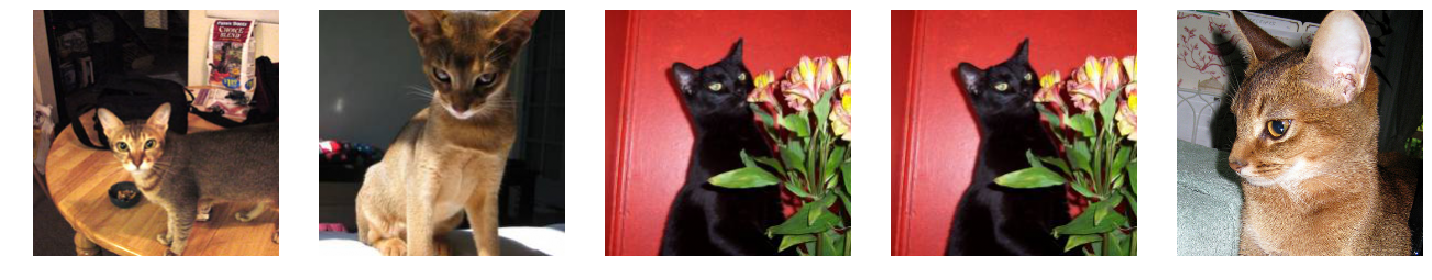

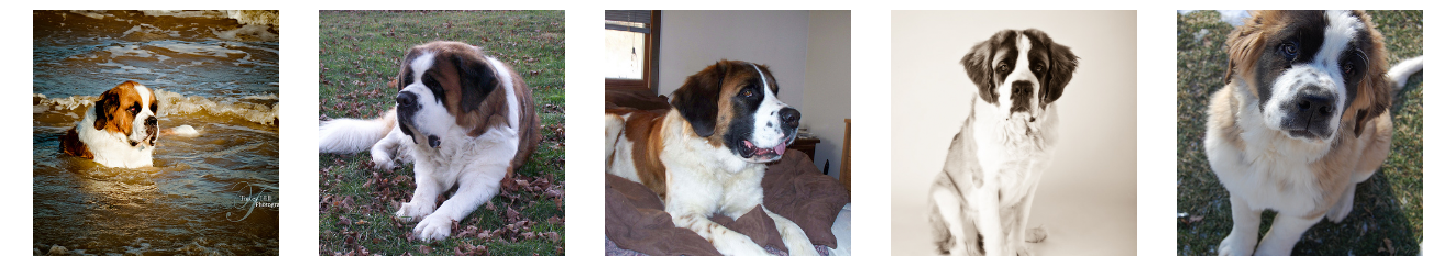

In [389]:
f=0
print(f'Pets with LEAST / MOST of feature {f}')
show_valid(sorts[f][-6:-1])
show_valid(sorts[f][0:5])

Pets with LEAST / MOST of feature 1


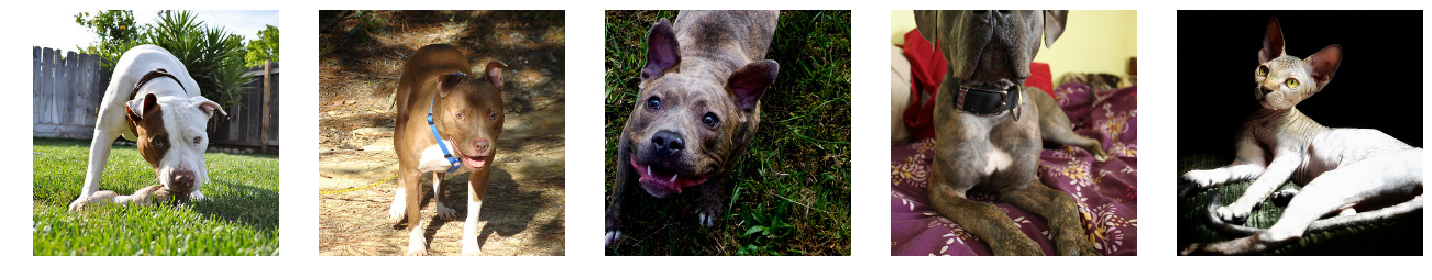

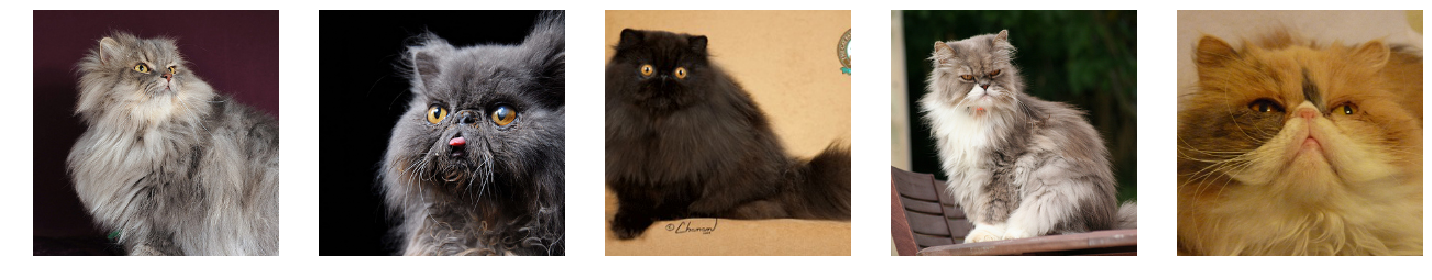

In [388]:
f=1
print(f'Pets with LEAST / MOST of feature {f}')
show_valid(sorts[f][-6:-1])
show_valid(sorts[f][0:5])

In [360]:
# normalize the PCA features (mean=0, sd=1, so we can find the ones which score highest on both dimensions)
from sklearn.preprocessing import normalize
nPCA_X_valid = normalize(PCA_X_valid)

In [382]:
# make a dataframe with the top 3 features
df = pd.DataFrame({'doggyness':nPCA_X_valid[:,0],
              'hairyness':nPCA_X_valid[:,1]})

df['naked_cat'] = (-1*df.doggyness)**0.5 + (-1*df.hairyness)**0.5
df['naked_dog'] = (1*df.doggyness)**0.5 + (-1*df.hairyness)**0.5
df['hairy_cat'] = (-1*df.doggyness)**0.5 + (1*df.hairyness)**0.5
df['hairy_dog'] = (1*df.doggyness)**0.5 + (1*df.hairyness)**0.5

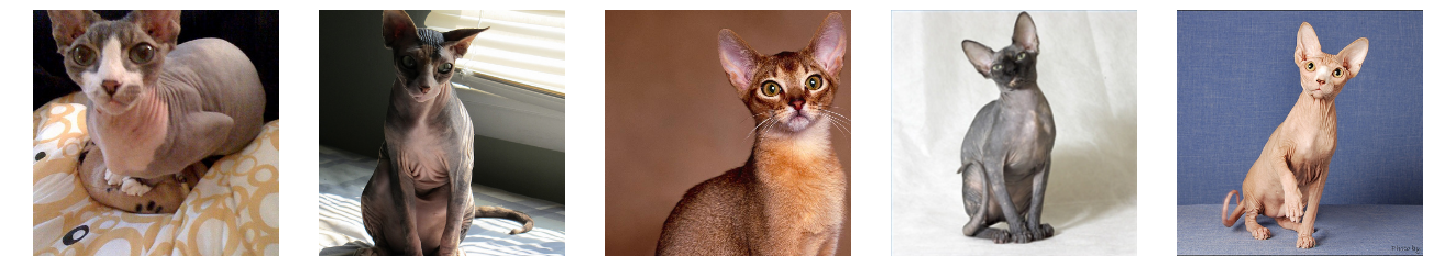

In [384]:
show = 'naked_cat'
df = df.sort_values(by=show,ascending=False)
show_valid(df.index[0:5])

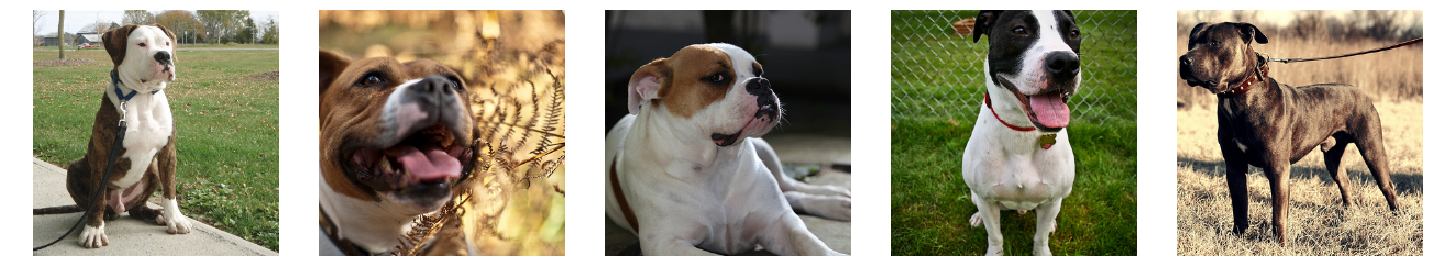

In [386]:
show = 'naked_dog'
df = df.sort_values(by=show,ascending=False)
show_valid(df.index[0:5])

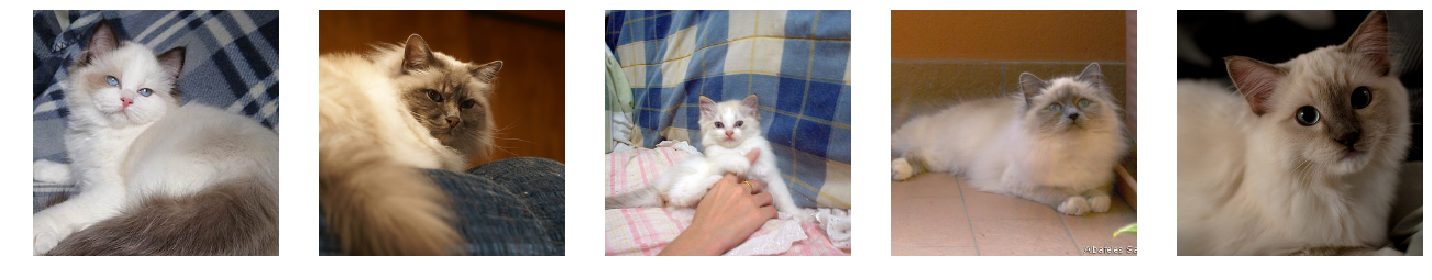

In [387]:
show = 'hairy_cat'
df = df.sort_values(by=show,ascending=False)
show_valid(df.index[0:5])

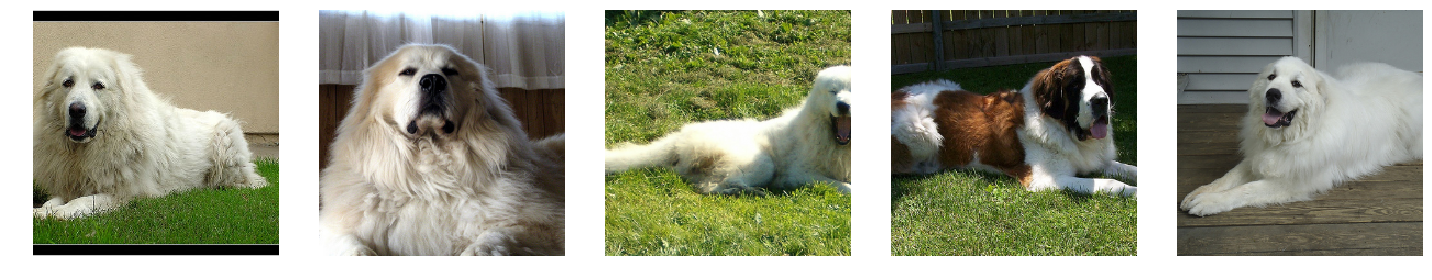

In [385]:
show = 'hairy_dog'
df = df.sort_values(by=show,ascending=False)
show_valid(df.index[0:5])

In [1]:
print("End of story :-)")

End of story :-)
